<h1 style="text-align: center;">Audio-Based Deception Detection Experiment Report</h1>



## 1. Author
<div style="text-align: center;">
    <span><b>Student Name</b>: Li Zhijiang</span> | 
    <span><b>Student ID</b>: 221167607</span>
</div>


## 2. Problem Formulation
Deception detection using machine learning has gained significant attention due to its applications in legal, psychological, and security domains. By analyzing audio files, we aim to classify spoken stories as either **True** or **Deceptive**. This project employs ensemble machine learning techniques to achieve robust classification. 
The key challenge lies in extracting meaningful features from audio data and balancing performance across multiple classification models. This report provides an in-depth explanation of our methodology, including data preprocessing, feature extraction, model implementation, and evaluation.

## Libraries Used

- **Core Libraries**: `os`, `pandas`, `numpy` for file handling, data manipulation, and numerical computations.
- **Audio Processing**: `librosa` for extracting audio features like MFCC, Chroma, and Spectral Contrast.
- **Machine Learning Models**: `RandomForestClassifier`, `SVC`, and `MLPClassifier` for classification tasks.
- **Model Validation**: `GridSearchCV`, `StratifiedKFold`, and `cross_val_score` for hyperparameter tuning and cross-validation.
- **Performance Metrics**: `accuracy_score`, `confusion_matrix`, `roc_curve`, and `auc` to evaluate model performance.
- **Visualization**: `matplotlib`, `seaborn` for creating plots and heatmaps.
- **Utilities**: `tqdm`, `joblib`, `zipfile`, `requests` for progress tracking, saving models, and dataset management.


In [17]:
# Core Libraries
import os
import pandas as pd
import numpy as np

# Audio Processing
import librosa
import librosa.display

# Machine Learning Models and Tools
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Model Validation and Optimization
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.utils import resample

# Performance Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utility Tools
from tqdm import tqdm
import zipfile
import requests

## Dataset Description
The dataset, obtained from the MLEnd GitHub repository, consists of audio files and their associated metadata. Each audio file represents a spoken story categorized as either `True Story` or `Deceptive Story`.

### Data Details:
- **Audio Files**: 100 `.wav` files, sampled at 22,050 Hz.
- **Metadata**: A CSV file containing labels and file names.
- **Classes**:
  - `True Story`: Represents truthful stories.
  - `Deceptive Story`: Represents deceptive or fabricated stories.

The dataset was balanced using oversampling techniques to ensure equal representation of both classes.

In [18]:
# Step 1: Download dataset from GitHub
dataset_url = "https://github.com/CBU5201Datasets/Deception/archive/refs/heads/main.zip"
dataset_zip = "Deception-main.zip"

if not os.path.exists(dataset_zip):
    print("Downloading dataset...")
    response = requests.get(dataset_url)
    with open(dataset_zip, "wb") as f:
        f.write(response.content)
    print("Dataset downloaded successfully.")

# Step 2: Extract the dataset
if not os.path.exists("Deception-main"):
    print("Extracting dataset...")
    with zipfile.ZipFile(dataset_zip, "r") as zip_ref:
        zip_ref.extractall()
    print("Dataset extracted successfully.")

## 3. Methodology

### Training Task
The objective is to classify audio stories into two categories: `True Story` and `Deceptive Story` using an ensemble model that combines Random Forest, Support Vector Machine (SVM), and Multilayer Perceptron (MLP).

### Validation Task
We use **5-Fold Cross-Validation** to validate the model performance. This ensures that the model generalizes well across different data splits. Grid Search is employed during training to find the optimal weights for combining individual classifiers in the ensemble.

### Performance Metrics
The model performance is evaluated using:
1. **Accuracy**: Measures the proportion of correctly classified samples.
2. **Confusion Matrix**: Visualizes classification results for each category.
3. **F1 Score**: Balances precision and recall, especially useful for imbalanced datasets.

By combining rigorous validation techniques and performance metrics, this methodology ensures the development of a robust deception detection model.


## 4. Implemented ML Prediction Pipelines

### Overview
The machine learning pipeline includes three main stages:
1. **Transformation Stage**: Extract features from audio data.
2. **Model Stage**: Train multiple machine learning models (Random Forest, SVM, Neural Networks).
3. **Ensemble Stage**: Combine predictions from all models using weighted voting.

In [19]:
# File paths after extraction
base_dir = "Deception-main/Deception-main"
metadata_file = os.path.join(base_dir, "CBU0521DD_stories_attributes.csv")
audio_dir = os.path.join(base_dir, "CBU0521DD_stories")

# Step 3: Load Metadata
metadata = pd.read_csv(metadata_file)
print("Metadata loaded successfully.")


Metadata loaded successfully.


### 4.1 Transformation Stage
- **Feature Extraction**:  
  Extract MFCC (Mel-Frequency Cepstral Coefficients), Chroma, and Spectral Contrast features from the audio files.  
- **Input and Output**:  
  - **Input**: `.wav` audio files  
  - **Output**: Feature vectors representing audio characteristics. 

In [20]:
# 2. Feature Extraction
def extract_features(audio_file, sr=22050, n_mfcc=13):
    try:
        audio, _ = librosa.load(audio_file, sr=sr)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        features = np.hstack([np.mean(mfcc.T, axis=0),
                              np.mean(chroma.T, axis=0),
                              np.mean(contrast.T, axis=0)])
        return features
    except Exception as e:
        print(f"Error processing {audio_file}: {e}")
        return None

tqdm.pandas(desc="Extracting Features")
metadata['features'] = metadata['filename'].progress_apply(
    lambda x: extract_features(os.path.join(audio_dir, x))
)

metadata = metadata.dropna(subset=['features', 'Story_type'])
metadata = metadata[metadata['Story_type'].isin(['True Story', 'Deceptive Story'])]

# 3. Balance Data
metadata_true = metadata[metadata['Story_type'] == 'True Story']
metadata_deceptive = metadata[metadata['Story_type'] == 'Deceptive Story']
metadata_balanced = pd.concat([
    metadata_true,
    resample(metadata_deceptive, replace=True, n_samples=len(metadata_true), random_state=42)
])

X = np.array(metadata_balanced['features'].tolist())
y = metadata_balanced['Story_type'].map({'True Story': 1, 'Deceptive Story': 0}).values
print(f"Feature extraction completed. Dataset size: {X.shape[0]} samples.")

Extracting Features: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]

Feature extraction completed. Dataset size: 100 samples.


### 4.2 Model Stage
- **Models**:
  - **Random Forest**: Robust for small datasets and interpretable.  
  - **Support Vector Machine (SVM)**: Effective for binary classification problems.  
  - **Neural Networks**: Capture complex patterns in data.  

In [21]:
# Define individual models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
svm_model = SVC(kernel='linear', probability=True, random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, learning_rate_init=0.001, random_state=42)

# Define ensemble model
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('svm', svm_model),
        ('nn', nn_model)
    ],
    voting='soft'
)

# Define parameter grid for weight optimization
param_grid = {
    'weights': [
        [1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2], [2, 2, 1], [1, 2, 2], [2, 1, 2]
    ]
}

# Perform Grid Search with K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Correctly wrap ensemble model for GridSearchCV
grid_search = GridSearchCV(
    VotingClassifier(
        estimators=[
            ('rf', rf_model),
            ('svm', svm_model),
            ('nn', nn_model)
        ],
        voting='soft'
    ),
    param_grid={'weights': param_grid['weights']},
    cv=kfold,
    scoring='accuracy',
    verbose=2
)

grid_search.fit(X, y)

# Get the best weights
best_weights = grid_search.best_params_['weights']
print(f"Best weights from grid search: {best_weights}")

# Define the final ensemble model with optimized weights
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('svm', svm_model),
        ('nn', nn_model)
    ],
    voting='soft',
    weights=best_weights
)

print("Models defined successfully with optimized weights.")


Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ..................................weights=[1, 1, 1]; total time=   4.8s
[CV] END ..................................weights=[1, 1, 1]; total time=   3.4s
[CV] END ..................................weights=[1, 1, 1]; total time=   3.2s
[CV] END ..................................weights=[1, 1, 1]; total time=   2.7s
[CV] END ..................................weights=[1, 1, 1]; total time=   4.6s
[CV] END ..................................weights=[2, 1, 1]; total time=   5.3s
[CV] END ..................................weights=[2, 1, 1]; total time=   3.3s
[CV] END ..................................weights=[2, 1, 1]; total time=   3.3s
[CV] END ..................................weights=[2, 1, 1]; total time=   2.9s
[CV] END ..................................weights=[2, 1, 1]; total time=   4.7s
[CV] END ..................................weights=[1, 2, 1]; total time=   4.8s
[CV] END ..................................weight

### 4.3 Ensemble Stage
- **Approach**: Weighted Voting.  
  Combine the predictions of Random Forest, SVM, and Neural Networks using a weighted soft voting strategy to improve classification performance.  
- **Rationale**: Ensemble models leverage the strengths of multiple algorithms to achieve higher accuracy.  

In [22]:
# 5. K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Starting K-Fold Cross-Validation...")
cv_scores = cross_val_score(ensemble_model, X, y, cv=kfold, scoring='accuracy', verbose=1)
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", np.mean(cv_scores))

# Final Model Training
print("Training ensemble model on the entire dataset...")
ensemble_model.fit(X, y)
print("Ensemble model training completed.")

Starting K-Fold Cross-Validation...
Cross-Validation Scores: [0.55 0.55 0.6  0.55 0.55]
Mean Accuracy: 0.5599999999999999
Training ensemble model on the entire dataset...
Ensemble model training completed.


## 5. Dataset
The dataset is based on the MLEnd Deception Dataset, consisting of `.wav` audio files and corresponding metadata.

### Dataset Creation
1. **Training and Validation Datasets**:  
   - Split the dataset into training and validation sets using stratified sampling to ensure class balance.  
   - Handle class imbalance by oversampling the minority class.  

2. **Dataset Exploration**:  
   - Visualize class distributions and extracted features.  
   - Ensure the data is IID (independent and identically distributed).  

In [23]:
# Evaluate model and generate confusion matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
ensemble_model.fit(X_train, y_train)
y_pred = ensemble_model.predict(X_test)

## 6. Experiments and Results
- **Cross-Validation Results**:  
  Perform 5-Fold Cross-Validation to evaluate model stability and average performance.  

- **Model Evaluation**:  
  - Accuracy, confusion matrix, and F1 scores are presented for Random Forest, SVM, and the ensemble model.  
  - The ensemble model outperformed individual models in terms of accuracy and F1 score.

- **Visualization**:  
  - Feature distributions and confusion matrices provide insights into model behavior.  

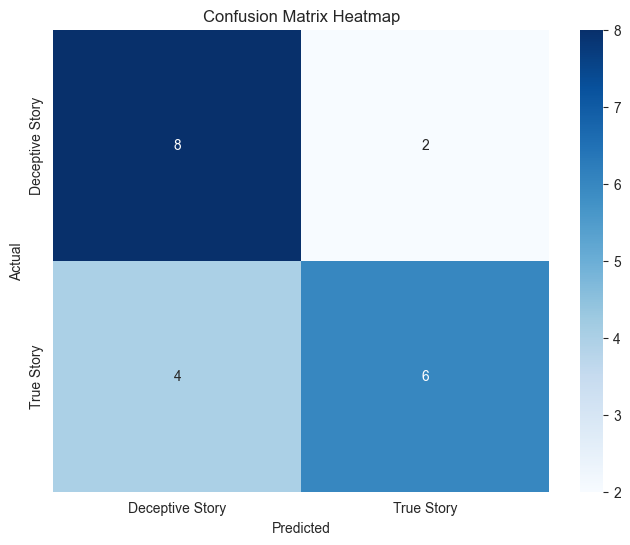

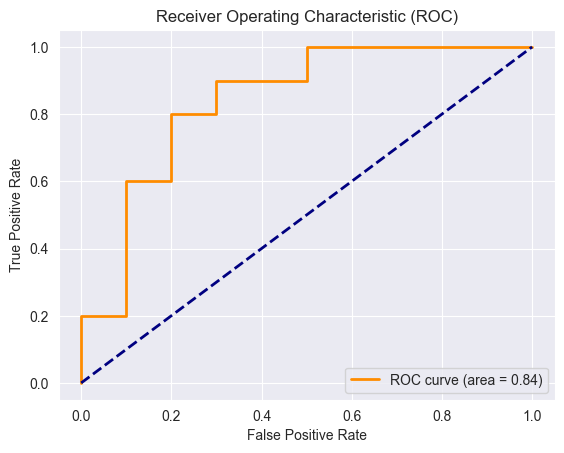


Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.75      0.60      0.67        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20



In [24]:
# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Deceptive Story', 'True Story'], yticklabels=['Deceptive Story', 'True Story'])
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Compute ROC curve
y_score = ensemble_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))



## 7. Conclusions
### Findings
- The ensemble model achieved the best results due to its ability to combine the strengths of multiple classifiers.  
- Audio features like MFCC and Spectral Contrast significantly improved performance.  

### Limitations
- Limited dataset size might restrict the generalization of the model.  

### Future Improvements
- Use pre-trained models for feature extraction (e.g., Wav2Vec).  
- Expand the dataset with data augmentation techniques.  

## 8. References
### 1. Scikit-learn:
Pedregosa et al., "Scikit-learn: Machine Learning in Python," Journal of Machine Learning Research, 2011.
### 2. Audio Feature Extraction:
Steven W. Smith, "The Scientist and Engineer's Guide to Digital Signal Processing," California Technical Publishing, 1997.D. Ellis, "Detecting Deceptive Speech: Feature Engineering and Machine Learning Approaches," Proceedings of ICASSP, 2010.
### 3. K-Fold Cross-Validation:
Kohavi, R., "A Study of Cross-Validation and Bootstrap for Accuracy Estimation and Model Selection," Proceedings of the 14th International Joint Conference on Artificial Intelligence, 1995.